In [41]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import sklearn
import pandas as pd
import scipy.stats as stats

In [2]:
neuron_data = {}



In [3]:
files = os.listdir('../neuron_logs/train_data')

In [170]:
with open(os.path.join('..', 'neuron_logs', 'train_data', 'output_20190923-192628.json'), 'r') as f:
    neuron_data = json.load(f)

target = 'usefulness_loss'


target_thr = [neuron_data[e][neuron][target] for neuron in neuron_data['0'] for e in neuron_data  if e != '0' and ' ' in neuron]

threshold = np.percentile(target_thr, 90) # median

print(threshold)



1.6581112265586857


In [171]:
print(neuron_data['1']['0 0'].keys())
np.array(neuron_data['1']['3 0']['output_weights']).shape

dict_keys(['activations', 'usefulness_loss', 'usefulness_acc', 'depth', 'inverse_depth', 'width', 'input_weights', 'output_weights', 'reg_loss_in_layer'])


(10,)

In [172]:
def reduce_to_statistics(activations, labels, debug=False):
    sorted_data = []
    for i in range(10): #hardcoded MOFO
        sorted_data += [[]]
    for i, a in zip(labels, activations):
        sorted_data[i] += [a]
    if debug:
        return(sorted_data)
    statistics = []
    for ar in sorted_data:
        curr_stats = stats.describe(ar)
        statistics += [curr_stats.mean, curr_stats.variance, curr_stats.skewness, curr_stats.kurtosis, curr_stats.minmax[0],
                       curr_stats.minmax[1], curr_stats.nobs]
        #print(statistics)
    return(statistics)

In [173]:
train, test = [], []
for i, filename in enumerate(files[:2]):
    with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
        neuron_data = json.load(f)
    if i == 10:
        break
    for e in neuron_data.keys():
        if e == '0' or int(e) > 3:
            continue
        for neuron in neuron_data[e]:
            if ' ' not in neuron:
                continue
            current_data = neuron_data[e][neuron]
            important_features = []
            #important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
            important_features = current_data['activations'][:500]
            important_features += [current_data['depth']]
            important_features += [current_data['inverse_depth']]
            important_features += [current_data['width']]
            # important_features += [current_data['input_weights']]
            # important_features += [current_data['output_weights']]
            important_features += [current_data['reg_loss_in_layer']]
            train += [important_features]
            test += [int(current_data[target] > threshold)]

In [174]:
train = np.array(train)
test = np.array(test)

In [175]:
print(train.shape, test.shape)

(720, 504) (720,)


In [176]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)
print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
clf.score(X_test, y_test) 

(576, 504) (144, 504) (576,) (144,)


0.9236111111111112

In [114]:
clf.coef_

array([[-1.32120456e-01, -5.46054235e-01, -2.13130681e-01,
        -2.66430547e-01, -1.26884871e-01,  2.34496659e-01,
        -7.86217115e-04,  2.41716901e-01, -3.77585067e-02,
         5.40149746e-01, -1.53413039e-01, -2.65328278e-01,
         3.58518707e-01, -8.44132130e-04,  2.60591895e-01,
         2.43013111e-02,  3.02438517e-01,  1.03921110e-01,
        -4.03443389e-01,  5.02036882e-01, -7.85423736e-04,
         3.10451153e-01,  8.39404810e-03,  1.41849603e-01,
        -3.36392453e-01, -3.52743438e-01,  2.14508419e-01,
        -8.17157995e-04,  9.96351709e-02, -2.82241183e-01,
         2.01286273e-01,  4.77277083e-02, -7.80988275e-01,
        -9.35321838e-02, -7.79870339e-04,  1.74389187e-01,
        -3.16228875e-01, -1.03751621e-01, -3.65055692e-01,
         4.97258715e-01, -9.90957524e-02, -7.25921943e-04,
         1.33640353e-01, -2.93801411e-01,  4.00054177e-01,
         4.69141094e-01,  6.41159197e-02,  7.47577829e-02,
        -7.67176493e-04,  2.51085036e-01, -5.56680525e-0

In [85]:
clf.score(X_train, y_train)

0.8166666666666667

In [86]:
np.argsort(np.abs(clf.coef_))
#clf.coef_[0][10000]

array([[35, 14, 24, 42,  3, 18, 33, 19, 34, 37, 27, 17, 21, 32, 39,  7,
         8, 25, 36, 15, 11, 28, 16, 38, 20,  4, 23, 26, 30, 41,  2, 10,
        22, 43, 13, 12, 31,  0, 29,  6,  5,  1,  9, 40]])

In [87]:
sorted(np.abs(clf.coef_)[0], reverse=True)

[1.673466264199148,
 1.3931983786172248,
 1.3609646495077448,
 1.1808303679732206,
 1.1084977995972152,
 0.9625058495082788,
 0.9609125906963265,
 0.7002358099089452,
 0.6696634105210421,
 0.63849680047462,
 0.629008764141674,
 0.5894373317605294,
 0.5693977247703768,
 0.47111225503829623,
 0.4442808664667496,
 0.42520268106057557,
 0.41281068253638475,
 0.39163864847446556,
 0.3416550359365741,
 0.3362720697428224,
 0.2946802342257904,
 0.26832188463284673,
 0.26450756974594153,
 0.25760475854562825,
 0.21260076918805906,
 0.2097503730171995,
 0.1967097259861429,
 0.19566432377194068,
 0.16881596047770064,
 0.16486119572531133,
 0.15627494051392007,
 0.13172571879543218,
 0.1243778090046361,
 0.11257936997587963,
 0.1111809763020016,
 0.09736815703563934,
 0.053079743535887874,
 0.03797586326553398,
 0.036017924305543965,
 0.03340058342174826,
 0.03094543126598155,
 0.020224336219541426,
 0.0193033911058047,
 0.0017554394424272122]

In [16]:
clf.coef_[0]

array([-0.43740408,  0.22133338, -0.15104726, ...,  0.55883037,
       -0.02457438, -0.87689349])

In [101]:
scores = {}
for c in [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]:
    train, test = [], []
    for i, filename in enumerate(files[:2]):
        with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
            neuron_data = json.load(f)
        if i == 10:
            break
        for e in neuron_data.keys():
            if e == '0' or e > 5:
                continue
            for neuron in neuron_data[e]:
                if ' ' not in neuron:
                    continue
                current_data = neuron_data[e][neuron]
                important_features = []
                important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
                #important_features = current_data['activations'][:c]
                important_features += [current_data['depth']]
                important_features += [current_data['inverse_depth']]
                important_features += [current_data['width']]
                # important_features += [current_data['input_weights']]
                # important_features += [current_data['output_weights']]
                important_features += [current_data['reg_loss_in_layer']]
                train += [important_features]
                test += [int(current_data[target] > threshold)]

    train = np.array(train)
    test = np.array(test)
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)
    print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
    clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    print(c, clf.score(X_test, y_test))
    scores[c] = clf.score(X_test, y_test)

(1920, 54) (480, 54) (1920,) (480,)
50 0.85625
(1920, 104) (480, 104) (1920,) (480,)
100 0.875
(1920, 204) (480, 204) (1920,) (480,)
200 0.9083333333333333
(1920, 504) (480, 504) (1920,) (480,)
500 0.9291666666666667
(1920, 1004) (480, 1004) (1920,) (480,)
1000 0.9333333333333333
(1920, 2504) (480, 2504) (1920,) (480,)
2500 0.9416666666666667
(1920, 5004) (480, 5004) (1920,) (480,)
5000 0.9479166666666666
(1920, 7504) (480, 7504) (1920,) (480,)
7500 0.9479166666666666
(1920, 10004) (480, 10004) (1920,) (480,)
10000 0.9416666666666667


Text(0.5, 1.0, 'Accuracy versus sample size from 10000 activations')

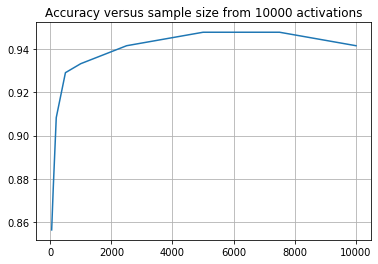

In [115]:
counts, accuracies = zip(*sorted(list(scores.items()), key = lambda x: x[0]))
plt.figure(facecolor = 'w')
plt.plot(counts, accuracies)
plt.grid()
plt.title('Accuracy versus sample size from 10000 activations')

In [118]:
e = 5
current_data = neuron_data[e][neuron]
some_data = reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'], debug=True) 

Text(0.5, 1.0, "Distribution of some neuron's activations")

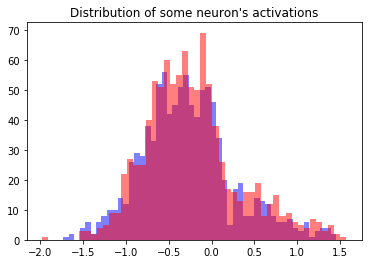

In [134]:
num = 6
plt.hist(some_data[num], bins = 50, alpha = 0.5, color = 'blue')
plt.hist(some_data[num-2], bins = 50, alpha = 0.5, color = 'red')
plt.title('Distribution of some neuron\'s activations')

In [ ]:
plt.hist()